In [4]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import transforms as T
import torchvision.models as models
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
import wandb
from torchvision.utils import make_grid

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
# Utility function for Poisson Image Editing
def poisson_blend(source_img, target_img, mask, center):
    return cv2.seamlessClone(source_img, target_img, mask, center, cv2.NORMAL_CLONE)

In [6]:
def poisson_blend_random_scale(source_path, target_path):
    """
    Perform Poisson blending between a source and target image with a random scaling factor between 0.1 and 0.5.
    
    Args:
        source_path (str): Path to the source image (e.g., tiger).
        target_path (str): Path to the target image (e.g., road).
        output_path (str): Path to save the blended output image.
    
    Returns:
        blended_img (numpy.ndarray): The result of the Poisson blending.
    """
    # Load source and target images
    source_img = cv2.imread(source_path)  # Source image (e.g., tiger)
    target_img = cv2.imread(target_path)  # Target image (e.g., road)
    
    if source_img is None or target_img is None:
        print("Error: One or both images couldn't be loaded.")
        return None

    # Generate a random scale factor between 0.1 and 0.5
    scale_factor = random.uniform(0.1, 0.5)
    print(f"Scaling the source image by a factor of {scale_factor:.2f}")

    # Resize the source image based on the random scale factor
    resized_source_img = cv2.resize(source_img, (0, 0), fx=scale_factor, fy=scale_factor)
    
    # Create a white mask for the resized source image
    resized_mask = np.ones(resized_source_img.shape[:2], dtype=np.uint8) * 255  # Binary mask for Poisson blending

    # Choose a center point where to place the source image on the target image
    center_x = random.randint(resized_source_img.shape[1] // 2, target_img.shape[1] - resized_source_img.shape[1] // 2)
    center_y = random.randint(resized_source_img.shape[0] // 2, target_img.shape[0] - resized_source_img.shape[0] // 2)
    center = (center_x, center_y)

    # Print the center for debugging purposes
    print(f"Placing the source image at the center position: {center}")

    # Perform Poisson blending using seamlessClone
    blended_img = cv2.seamlessClone(resized_source_img, target_img, resized_mask, center, cv2.NORMAL_CLONE)

    # Save the blended image
    output_path = "../datasets/testing_images/blended.jpg"
    cv2.imwrite(output_path, blended_img)
    # print(f"Blended image saved to {output_path}")

    # Optionally, display the blended image
    cv2.imshow('Blended Image', blended_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return blended_img

In [7]:
source_img = '../datasets/testing_images/tiger-4.jpg'
target_img = '../datasets/testing_images/road.jpg'

# print(source_img.shape)
# print(target_img.shape)

blended_img = poisson_blend_random_scale(source_img, target_img)

# # Create a binary mask
# mask = np.zeros_like(source_img[:, :, 0])
# mask[50:150, 50:150] = 255  # Mask the area to blend

# # Define the center where the source will be blended on the target
# center = (100, 100)

# # Apply Poisson blending
# result = poisson_blend(source_img, target_img, mask, center)

# # Show the result
# cv2.imshow('Blended Image', result)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

Scaling the source image by a factor of 0.40
Placing the source image at the center position: (1522, 1081)


In [5]:
# class MVTecDataset(Dataset):
#     def __init__(self, root_dir, class_name, transform=None, mode='train', create_anomalies=False):
#         self.root_dir = root_dir
#         self.class_name = class_name
#         self.mode = mode  # 'train', 'test', 'val'
#         self.transform = transform
#         self.create_anomalies = create_anomalies

#         if mode == 'train':
#             self.image_dir = os.path.join(self.root_dir, self.class_name, 'train', 'good')
#             print("self.image_dir 1 : ", self.image_dir)
#         else:
#             self.image_dir = os.path.join(self.root_dir, self.class_name, mode)
#             print("self.image_dir 2 : ", self.image_dir)

#         self.image_paths = [os.path.join(self.image_dir, fname) for fname in os.listdir(self.image_dir) if fname.endswith('.png')]

#         # If creating synthetic anomalies, the 'good' images will be used to generate them
#         if self.create_anomalies and mode == 'train':
#             self.anomaly_source_images = self.image_paths  # Use the same 'good' images to create anomalies

#     def __len__(self):
#         return len(self.image_paths)
    
#     def __getitem__(self, idx):
#         img_path = self.image_paths[idx]
#         image = cv2.imread(img_path)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         label = 0  # Normal class
#         mask = np.zeros_like(image[:, :, 0])  # Initialize mask as blank
        
#         if self.create_anomalies and random.random() < 0.5:
#             # Choose another random image from 'good' images to act as the source of the anomaly
#             anomaly_img_path = random.choice(self.anomaly_source_images)
#             anomaly_image = cv2.imread(anomaly_img_path)
#             anomaly_image = cv2.cvtColor(anomaly_image, cv2.COLOR_BGR2RGB)
            

#             # Create mask for Poisson blending
#             h, w, _ = image.shape
#             mask = 255 * np.ones(anomaly_image.shape[:2], dtype=anomaly_image.dtype)

#             # Ensure the patch center is within valid bounds
#             patch_h, patch_w, _ = anomaly_image.shape
#             valid_center_x = random.randint(patch_w // 2, w - patch_w // 2)
#             valid_center_y = random.randint(patch_h // 2, h - patch_h // 2)
#             center = (valid_center_x, valid_center_y)
            
#             # Apply Poisson blending to create anomaly
#             image = poisson_blend(anomaly_image, image, mask, center)
#             label = 1  # Anomalous class
        
#         if self.transform:
#             image = self.transform(image)

#         return image, label, mask

In [6]:
CLASS_NAMES = ['bottle', 'cable', 'capsule', 'carpet', 'grid',
               'hazelnut', 'leather', 'metal_nut', 'pill', 'screw',
               'tile', 'toothbrush', 'transistor', 'wood', 'zipper']
OBJECTS = ['bottle', 'cable', 'capsule', 'hazelnut', 'metal_nut', 
            'pill', 'screw', 'toothbrush', 'transistor', 'zipper']
TEXTURES = ['carpet', 'grid', 'leather', 'tile', 'wood']

In [7]:
class MVTecDataset(Dataset):
    def __init__(self, root_path, class_name='bottle', is_train=True,
                 create_anomalies=False, low_res=256, transform=None):
        assert class_name in CLASS_NAMES, f'class_name: {class_name}, should be in {CLASS_NAMES}'
        
        self.root_path = root_path
        self.class_name = class_name
        self.is_train = is_train
        self.create_anomalies = create_anomalies
        self.low_res = low_res
        self.transform = transform if transform is not None else T.Compose([
            T.Resize((low_res, low_res)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # Load dataset (images, labels, and masks)
        self.x, self.y, self.masks = self.load_dataset_folder()

        # If creating anomalies, store a copy of good images for Poisson blending
        if self.create_anomalies:
            self.good_images = [img for img, label in zip(self.x, self.y) if label == 0]
        else:
            self.good_images = None  # Ensure good_images is defined

    def __len__(self):
        return len(self.x)
    
    def configure_self_sup(self, on=True, self_sup_args={}):
        """Placeholder method for compatibility with NSA code"""
        self.create_anomalies = on
        self.self_sup_args = self_sup_args

    def __getitem__(self, idx):
        image, label, mask = self.x[idx], self.y[idx], self.masks[idx]
        
        # Convert PIL image to NumPy array
        image = np.asarray(image)

        # If training and synthetic anomalies are required
        if self.create_anomalies and label == 0 and self.good_images and random.random() < 0.5:
            anomaly_image = random.choice(self.good_images)
            anomaly_image = np.asarray(anomaly_image)
            mask = np.ones_like(image[:, :, 0]) * 255  # White mask for Poisson blending

            h, w, _ = image.shape
            patch_h, patch_w, _ = anomaly_image.shape
            center_x = random.randint(patch_w // 2, w - patch_w // 2)
            center_y = random.randint(patch_h // 2, h - patch_h // 2)
            center = (center_x, center_y)

            # Apply Poisson blending to create synthetic anomaly
            image = poisson_blend(anomaly_image, image, mask, center)
            label = 1  # Mark as anomaly

        # Convert back to PIL for consistent resizing
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)  # Resize and transform to tensor
        
        # Ensure mask is a tensor with correct shape
        mask = torch.tensor(mask, dtype=torch.float32)
        
        if mask.dim() == 2:  # If the mask is 2D (H, W), add channel dimension
            mask = mask.unsqueeze(0)

        # Resize the mask to the desired size (if not already resized)
        mask = T.Resize((self.low_res, self.low_res))(mask)
       
        return image, label, mask

    def load_dataset_folder(self):
        phase = 'train' if self.is_train else 'test'
        img_dir = os.path.join(self.root_path, self.class_name, phase)
        gt_dir = os.path.join(self.root_path, self.class_name, 'ground_truth')

        image_paths, labels, mask_paths = [], [], []

        for img_type in sorted(os.listdir(img_dir)):
            img_type_dir = os.path.join(img_dir, img_type)
            if not os.path.isdir(img_type_dir):
                continue

            img_fpath_list = sorted([os.path.join(img_type_dir, f) for f in os.listdir(img_type_dir) if f.endswith('.png')])
            image_paths.extend(img_fpath_list)

            # Load ground truth labels
            if img_type == 'good':
                labels.extend([0] * len(img_fpath_list))
                mask_paths.extend([None] * len(img_fpath_list))
            else:
                labels.extend([1] * len(img_fpath_list))
                gt_type_dir = os.path.join(gt_dir, img_type)
                img_fname_list = [os.path.splitext(os.path.basename(f))[0] for f in img_fpath_list]
                gt_fpath_list = [os.path.join(gt_type_dir, img_fname + '_mask.png') for img_fname in img_fname_list]
                mask_paths.extend(gt_fpath_list)

        images = [Image.open(path).convert('RGB') for path in image_paths]
        mask_transform = T.Compose([T.Resize((self.low_res, self.low_res), interpolation=Image.NEAREST), T.ToTensor()])
        masks = [torch.zeros(1, self.low_res, self.low_res) if path is None else mask_transform(Image.open(path)) for path in mask_paths]

        return images, labels, masks


In [8]:
# # Example Usage
# dataset = MVTecDataset(root_path='./datasets/mvtec/', class_name='bottle', is_train=True, create_anomalies=True)
# data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [9]:
# for img, label, mask in data_loader:
#     print("image shape: ", img.shape, "label: ", label, "mask shape: ", mask.shape)

In [10]:
# # Transformations
# transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize((256, 256)),
#     transforms.ToTensor()
# ])

In [11]:
# # Example Usage
# root_dir = './datasets/mvtec'
# train_dataset = MVTecDataset(root_dir=root_dir, class_name='capsule', transform=transform, create_anomalies=True)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [8]:
# len(dataset)

209

In [9]:
# def show_images(images, labels, n=6):
#     plt.figure(figsize=(12, 6))
#     for i in range(n):
#         plt.subplot(2, n//2, i+1)
#         plt.imshow(images[i])
#         plt.title('Anomaly' if labels[i] == 1 else 'Normal')
#         plt.axis('off')
#     plt.show()

In [10]:
# # Get a batch of images from the DataLoader
# data_iter = iter(data_loader)
# images, labels, masks = next(data_iter)

/tmp/ipykernel_8380/1005212566.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


In [11]:
# # Convert Tensor to Numpy and rearrange dimensions from (B, C, H, W) to (B, H, W, C)
# images = images.numpy().transpose(0, 2, 3, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6041614..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6212862..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5870366..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6041614..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6212862..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6212862..2.64].


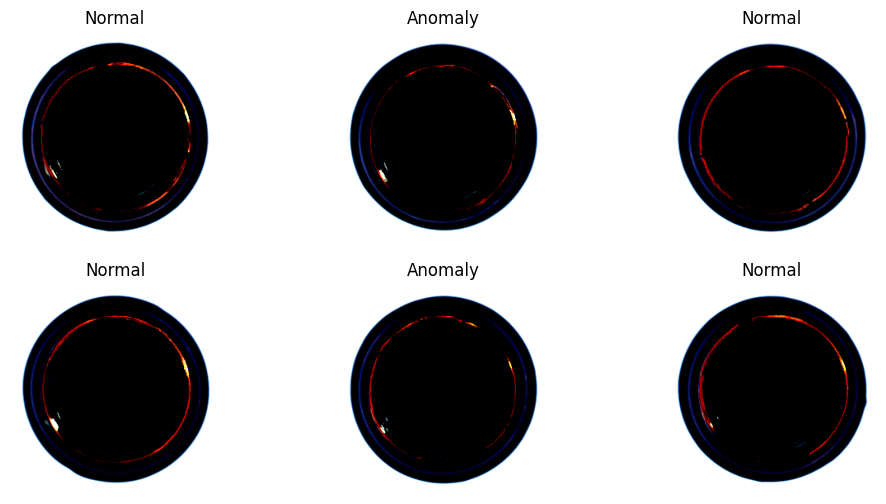

In [12]:
# show_images(images, labels.numpy(), n=6)

In [12]:
class TransposeBasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransposeBasicBlock, self).__init__()
        self.conv1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=1, stride=2, output_padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)

        # Perform upsampling path
        upsampled = self.upsample(x)

        return self.relu(out + upsampled)


class ResNetEncDec(nn.Module):
    def __init__(self):
        super(ResNetEncDec, self).__init__()

        # Encoder: Using ResNet layers up to layer4
        resnet = models.resnet18(pretrained=True)
        
        # Encoder layers
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4

        # NIN layer (512 -> 256 -> 128)
        self.nin = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=1, stride=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=1, stride=1, bias=False),
            nn.ReLU(inplace=True)
        )

        # Decoder (TransposeBasicBlock layers)
        self.uplayer1 = TransposeBasicBlock(128, 64)
        self.uplayer2 = TransposeBasicBlock(64, 32)
        self.uplayer3 = TransposeBasicBlock(32, 16)

        # Upsampling
        self.upsample = nn.Upsample(scale_factor=2.0, mode='bilinear')

        # Final conv layer
        self.convtranspose1 = nn.ConvTranspose2d(16, 1, kernel_size=7, stride=2, padding=3, output_padding=1, bias=False)

        # Final activation (Identity in this case)
        self.final_activation = nn.Identity()

    def forward(self, x):
        # Encoder
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # NIN Layer
        x = self.nin(x)

        # Decoder layers
        x = self.uplayer1(x)
        x = self.uplayer2(x)
        x = self.uplayer3(x)

        # Upsample
        x = self.upsample(x)

        # Final convolution
        x = self.convtranspose1(x)

        # Final activation (here it's Identity)
        x = self.final_activation(x)

        return x
    
model = ResNetEncDec()

/home/sameerhashmi36/miniconda3/envs/test/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sameerhashmi36/miniconda3/envs/test/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
model

ResNetEncDec(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=Tr

In [14]:
input_image = torch.randn(1, 3, 224, 224)  # Example input
output_image = model(input_image)
print(output_image.shape)

torch.Size([1, 1, 224, 224])


In [15]:
# Initialize wandb
wandb.init(project="mvtec-anomaly-detection", entity="sameerhashmi1995")  # Edit project and username

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: sameerhashmi1995. Use `wandb login --relogin` to force relogin


In [16]:
# SETTINGS for logging and saving
SETTINGS = {
    'Basic-Training-Example': {
        'fname': 'basic_training_example.pt',
        'out_dir': 'basic/',
        'loss': nn.BCEWithLogitsLoss,
        'final_activation': 'sigmoid',
        'seed': 12345,
        'self_sup_args': {'shift': True, 'resize': True}
    }
}

In [17]:
# Set seed for reproducibility
def set_seed(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)


In [18]:
# Function to save the model checkpoint
def save_model_checkpoint(model, optimizer, scheduler, epoch, out_dir, fname):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None
    }
    torch.save(checkpoint, os.path.join(out_dir, f'checkpoint_epoch_{epoch}_{fname}'))

In [19]:
def plot_predictions(model, loader_train, device, out_dir, epoch, fname):
    model.eval()
    
    # Get a batch of data
    data, labels, _ = next(iter(loader_train))
    data, labels = data.to(device), labels.to(device)
    
    # Get predictions from the model
    with torch.no_grad():
        preds = model(data)

    # Convert to CPU and float for plotting
    data = data.cpu().float()
    preds = preds.cpu().float()
    labels = labels.cpu().float()

    # Debugging: Check the shape of the tensors
    print(f"Data shape: {data.shape}, Labels shape: {labels.shape}, Predictions shape: {preds.shape}")
    
    # Ensure that the tensors have the correct dimensions (batch_size, channels, height, width)
    assert len(data.shape) == 4, "Data tensor should be 4D (batch, channels, height, width)"
    assert len(labels.shape) == 4, "Labels tensor should be 4D (batch, channels, height, width)"
    assert len(preds.shape) == 4, "Predictions tensor should be 4D (batch, channels, height, width)"
    
    # Plot predictions vs actual
    fig, ax = plt.subplots(1, 3, figsize=(12, 6))

    # Ensure data dimensions match the number of subplots (3 in this case)
    plot_images([data[:8], labels[:8], preds[:8]], ax)

    fig.tight_layout()
    fig.savefig(os.path.join(out_dir, f'epoch_{epoch}_{fname}.png'))
    plt.close(fig)

    
def plot_images(tensors, ax):
    for i, tensor in enumerate(tensors):
        # Convert tensor to float32 to avoid type issues
        tensor = tensor.float()
        
        # Use make_grid or other utility to create a grid of images for each subplot
        img_grid = make_grid(tensor, nrow=4, normalize=True)
        
        # Convert to numpy and transpose for correct display format
        np_img = img_grid.cpu().numpy()
        ax[i].imshow(np.transpose(np_img, (1, 2, 0)))
        ax[i].set_title(['Input', 'Labels', 'Predictions'][i])
        ax[i].axis('off')

In [20]:
# Training function
def train(class_name, data_dir, setting, device, model, dataset_class, epochs=10, batch_size=32, lr=1e-4):
    # Set the seed for reproducibility
    set_seed(setting.get('seed', 12345))

    # Set up dataset and data loader
    train_transform = T.Compose([
        T.RandomRotation(5),
        T.CenterCrop(230), 
        T.RandomCrop(224),
        T.ToTensor()
    ])
    
    # Load dataset
    train_dataset = dataset_class(root_path=data_dir, class_name=class_name, is_train=True, transform=train_transform)
    train_dataset.configure_self_sup(self_sup_args=setting.get('self_sup_args'))
    
    loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

    # Define optimizer and scheduler
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=lr / 10)
    loss_func = setting.get('loss')()

    # Set model to training mode and move to the device (GPU/CPU)
    model = model.to(device)
    model.train()

    # Create output directory if it doesn't exist
    out_dir = os.path.join(setting.get('out_dir'), class_name)
    os.makedirs(out_dir, exist_ok=True)

    train_loss_history = []

    # Training loop
    for epoch in tqdm(range(epochs), desc='Epoch'):
        epoch_loss = 0
        for batch_idx, (data, _, labels) in enumerate(tqdm(loader_train, desc='Batch')):
            data, labels = data.to(device), labels.to(device)

            # Resize labels to match the model's output size
            labels = F.interpolate(labels, size=(224, 224), mode='bilinear', align_corners=False)

            optimizer.zero_grad()
            preds = model(data)
            loss = loss_func(preds, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            # Log batch loss to wandb
            # wandb.log({"batch_loss": loss.item()})

        epoch_loss /= len(loader_train)
        train_loss_history.append(epoch_loss)

        # Log epoch loss to wandb
        # wandb.log({"epoch_loss": epoch_loss, "epoch": epoch})

        # Step the scheduler
        scheduler.step()

        # Save model checkpoint
        if (epoch + 1) % 10 == 0 or epoch == 0:
            save_model_checkpoint(model, optimizer, scheduler, epoch, out_dir, setting.get('fname'))

        # Plot example predictions at end of every epoch
        plot_predictions(model, loader_train, device, out_dir, epoch, setting.get('fname'))

    return train_loss_history

In [21]:
chosen_setting = SETTINGS['Basic-Training-Example']

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Batch:   0%|          | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_5427/2369343588.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)
/tmp/ipykernel_5427/2369343588.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)
/tmp/ipykernel_5427/2369343588.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)
/tmp/ipykernel_5427/2369343588.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTen

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 2)

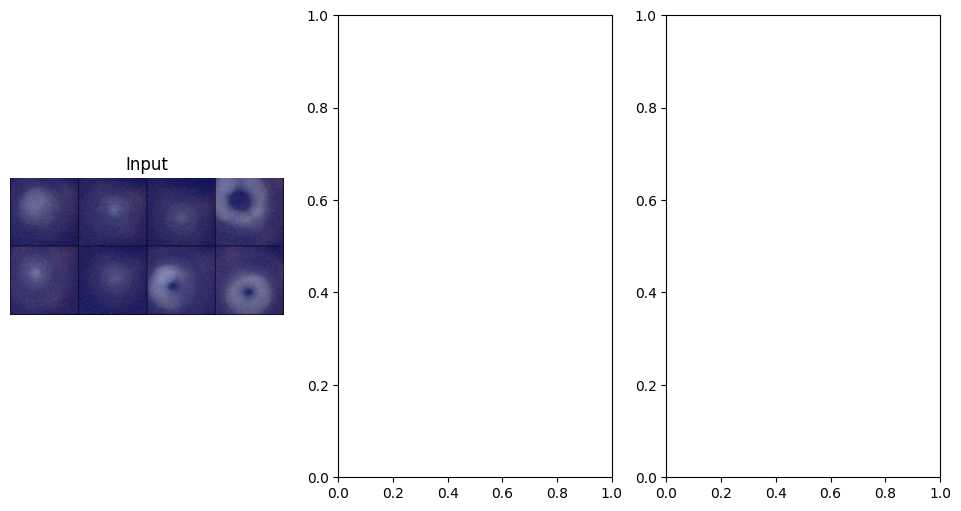

In [22]:
train_loss = train(
    class_name='bottle', 
    data_dir='./datasets/mvtec', 
    setting=chosen_setting, 
    device=device, 
    model=model, 
    dataset_class=MVTecDataset,
    epochs=20, 
    batch_size=32, 
    lr=1e-4
)